# TF-co-occurences for WP2 - Data
### Outline of this notebook:
    1. Constants, Path and Interface Definitions 
    2. Market Basket analysis with tf-comb, for all cluster/celltypes of a tissue
    3. Differential analysis with all market basket analysis (CombObj ´s) of step 2 for the clusters/celltypes of a single tissue. (One DiffCombObj for each tissue)
    4. Analysis for biological questions 
    
The aim is to find transcription-factor-co-occurences for cluster/celltypes of human tissues with the help of the python-library tf-comb. For the data of WP2. The data basis comes from the "cell atlas of chromatin accessibility across 25 adult human tissues"(https://doi.org/10.1101/2021.02.17.431699) 

**Biological question, that we want to answer with this notebook:**

1. Find Transcriptionfactor-co-occurences, which only occure in one (or more) "cluster/celltypes of a tissue".
    Maybe we can identify a cluster through this co-occurences.

**How to use this notbook:**
1. Please adapted the paths in Constants, Path and interface defintions for your approach
2. Please make sure you have installed the kernel as it is described in the ReadMe
3. Check if the WP2 Data structure is correctly provided (ReadMe).
    - Has all tissues as a folder in it: ../OUPTPUT_FOLDER/
    - You find the data (open cromatin regions per cluster .bed-files) e.g ../OUPTPUT_FOLDER/<tissue>/WP6/*cluster_x.bed
4. Execute each notebook window from top to bottom one after another.

## 1. Constants, Path and Interface Definitions:

In [1]:
from tfcomb import CombObj, DiffCombObj, utils
import os
import pathlib
import pandas as pd
import numpy as np
'''
Constants for this script.

This window contains all paths and constants, which are later used for this juypter notbook.

Please adapt paths or constants, if use other files. 
For example adapted the genome path, if you use another genome. 
'''

# Path to genome fasta file. Is used for the market basket analysis of tfcomb.
genome_path="/mnt/workspace_stud/allstud/homo_sapiens.104.mainChr.fa"

# Path to the jaspar file (contains transcription factors (TF) binding profiles
# as position frequency matrices (PFMs)). Is used for the market basket analysis of tfcomb
main_jaspar_file="../testdaten/JASPAR2020_CORE_vertebrates.meme" 

# Path where results of this notebook will be written to (eg. TF_COMB objects, .pkl).
result_path="./results/wp2/"

# Paths in the result folder:
# Path to folder, where the resulting market basket analysis for a cluster/celltype is put 
main_analysis_path=f"{result_path}main/"

# Path to folder, where the differential analysis for a tissue is put 
differential_analysis_path=f"{result_path}diff_analysis/"
# Path to folder, where answers of our results are put to
answers_path=f"{result_path}answers/"

# Path to folder (Interface folder) of wp2, where the clusters of each tissue can be found.
path_to_tissues="/mnt/workspace_stud/stud3/WP2_OUTPUT/FINISHED/"

# Tag for WP6 data in WP2 Interface
cluster_folder_tag="WP6/"

# Path to Folder with celltype annotation tables of wp2, not longer needed
#celltype_annotation_path = "/mnt/workspace_stud/stud4/celltype_assignment_tables/"

# The following lines, initally check if all file/paths are available. 
# If a result folder does not exist it is created automatically
if not os.path.exists(result_path):
     pathlib.Path(result_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(main_analysis_path):
     pathlib.Path(main_analysis_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(differential_analysis_path):
     pathlib.Path(differential_analysis_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(answers_path):
     pathlib.Path(answers_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(genome_path):
    print(f"ERROR: path {genome_path} does not exist")

if not os.path.exists(main_jaspar_file):
    print(f"ERROR: path {main_jaspar_file} does not exist")



### Helper functions for reading-in folders/files:

In [2]:
def get_folder_names_in_folder(rel_folder_path:str):
    ''' 
        Read in the names of the folders in a folder.(rel_folder_path)
        ---
        Parameters:
        
        rel_folder_path: String
            relative Path to the folder location that is read in.
        ---
        Return: a List of Strings (folder names)
    '''

    dirlist = [ item for item in os.listdir(rel_folder_path) if os.path.isdir(os.path.join(rel_folder_path, item))]
    folder_names = []
    for folder in dirlist:
        folder_names.append(folder)
    return folder_names

def read_in_file_names_of_folder(rel_path:str):
    ''' 
        Read in the file names in a folder (rel_path).
        ---
        Parameters:
        
        rel_path: String
            relative Path to the folder location.
        ---
        Return: a List of Strings (file names)
    '''
    return [f for f in os.listdir(rel_path) if os.path.isfile(os.path.join(rel_path, f))]


#cluster_file_names = read_in_file_names_of_folder(rel_path=path_to_clusters)


## 2. Market basket analysis with tf-comb
We do a market basket analysis with tfcomb for each cluster/celltype, which has been culstered by WP2 and comes from the raw single-cell ATAC-Data of the cell atlas project. As a result, we get the transcription-factor-co-occurences for each cluster. The Trancriptionsfactor motif´s come as a position-frequency-matrix from https://jaspar.genereg.net/search?q=&collection=CORE&tax_group=vertebrates. The corresponding genome, which is used is **homo_sapiens.104.mainChr.fa** .

Approach:
1. Read-in tissue folders of WP2
2. For each tissue: read-in single .bed (Content= open-chromatin regions) files for each cluster/celltype
3. Do market basket analysis for each cluster/celltype
4. Result .pkl CombObj files can be found under **/{result_path}/{main_analysis_path}/{tissue_name}/{cluster_name}.pkl **

In [3]:
def do_market_basket_analyses_for_cell_cluster(mb_file_name: str, cell_cluster_path:str, tissue:str):
    '''
        Does market basket analysis with tfcomb. Saves the tfcomb-Object as .pkl file to main_analysis_path.
        ---
        Paramater:
        
        mb_file_name: string
            Name for the result file of the market basket analyses. 
            e.g "<tissue>_<cluster_number>_<celltype>".
        
        cell_cluster_path: string
            Path to the .bed-File with genome regions to check for tf-co-occurences
         
        tissue: string
            Tissue name, origin of the cluster.
    '''    
    # Save path initalization, if folder for tissue does not exists, new folder is created.
    save_path = f'{main_analysis_path}{tissue}/'
    if not os.path.exists(save_path):
         pathlib.Path(save_path).mkdir(parents=True, exist_ok=True)
    
    # TF-comb market basket analysis
    comb = CombObj()
    comb.TFBS_from_motifs(regions= cell_cluster_path,
                   motifs=main_jaspar_file,
                   genome=genome_path,
                   threads=4)
    
    print(f'Start market basket analyses for cell-cluster/type: {mb_file_name}')
    comb.market_basket(threads=10)
    
    # if rules are empty nothing is saved 
    if len(comb.rules) <= 0:
        print(f'Could not find TF-cooccurences for cell-cluster/type: {mb_file_name}')
        return
    print(f'Finished market basket analyses for cell-cluster/type: {mb_file_name}')
    print(f'Found rules: {len(comb.rules)}')
    
    # save tf-comb obj to .pkl
    comb.to_pickle(f'{save_path}{mb_file_name}.pkl')
    print(f'Saved: {save_path}{mb_file_name}.pkl')

In [4]:
# Load tissue folder names for wp2 data
tissues=get_folder_names_in_folder(rel_folder_path=path_to_tissues)
print(tissues)

['IQYCP_lower_leg_skin', 'ACCPU_upper_lobe_of_left_lung', 'A8CPH_esophagus_muscularis_mucosa', 'A8WNZ_right_lobe_of_liver', 'ACCQ1_colon_transverse', 'AZPYJ_esophagus_squamous_epithelium', 'CHLWW_tibial_artery', 'IOBHK_tibial_artery']


### Functions for adding the celltype annotations of wp2 to the corresponding clusters

In [11]:
def get_celltype_annotation_table(celltype_annotation_path:str) -> pd.DataFrame:
    '''
    Read in the the given annotation file(celltype_annotation_path) with pandas read_table function
    ---
    Parameters:
    celltype_annotation_path : string
        Is the path to a file which has the celltype annotations for the cluster numbers.
        e.g. file content:
        6	Stromal cells
        3	Adipocyte progenitor cells
        4	Stromal cells
        7	Fibroblasts
    ---
    Returns a celltype annotation table as a pandas Dataframe.
    '''
    df = pd.DataFrame()
    df = pd.read_table(celltype_annotation_path, header=None, index_col=None)
    return df

def get_celltype_for_cluster(cluster_number: int, celltype_annotation_table: pd.DataFrame):
    '''
    Find celltype annotation for cluster number in the corresponding celltype_annotation_table
    ---
    Parameters:
    cluster_number: integer
        number of the cluster
    
    celltype_annotation_table: pd.DataFrame
        table with the celltype annotations, e.g. Dataframe
         0	1 
       1 6	Stromal cells
       2 3	Adipocyte progenitor cells
       3 4	Stromal cells
       4 7	Fibroblasts
    ---
    Returns the celltype for a cluster_number. (if no celltype kann be found "na" is returned) 
    '''
    # initalize celltype name with na (not available), if no celltype can be found na is returned
    celltype_name = "na"
    try:
        # Try to find the cell-type annotation in the table, if no annotation can be found key error is raised
        celltype_name = celltype_annotation_table[celltype_annotation_table[0] == int(cluster_number)].iat[0,1]
        # replace whitespaces in celltype names, e.g. "Stromal cell" -> "Stromal_cell"
        celltype_name = celltype_name.replace(" ", "_")
    except (KeyError, IndexError) as e:
        print(f"Could not find celltype annotation for cluster: {cluster_number}, set name to na.")
        celltype_name = "na"
   
    return celltype_name


'Melanocytes'

In [12]:
def make_mb_for_clusters(path_to_clusters:str, tissue:str):
    '''
        Wrapper function, that does the market basket analysis for all clusters/celltypes in a tissue.
        Also annotates the cluster with a celltype.
        ---
        Paramater:
        
        path_to_clusters: string
            Path to the .bed files(cluster) of a tissue.
         
        tissue: string
            Tissue name from where the cluster corresponds to.
        --- 
        Catch Exceptions with a message, if any error occures in the market basket analyses a message is printed
        and the programm continues with the next tissue.
    '''
    # Read in the .bed files for each cluster of the specific tissue
    cluster_file_names = read_in_file_names_of_folder(rel_path=path_to_clusters)
    print(cluster_file_names)
    
    # Get the celltype annotation table. To add celltype for a cluster. e.g. cluster6 = fibroblast
    celltype_table = get_celltype_annotation_table(
        celltype_annotation_path=f'{path_to_tissues}{tissue}/annotation/annotation.txt') # pandas dataframe is returned
    
    # Do a market basket analysis for each cluster of a tissue
    for file_name in cluster_file_names:
        # e.g JF1O6_body_of_pancreas.10_peaks.bed -> [JF1O6_body_of_pancreas.10_peaks] = clustername = JF1O6_body_of_pancreas.10_peaks
        cluster_name = file_name.split('.bed')[0]
        print(cluster_name)
        #e.g JF1O6_body_of_pancreas.10_peaks -> [JF1O6_body_of_pancreas, 10_peaks], cluster_number_with_tag = 10_peaks
        cluster_number_with_tag = cluster_name.split('.')[1]
        # e.g 10_peaks -> [10 , peaks], cluster_number = 10
        cluster_number = int(cluster_number_with_tag.split('_')[0])
        
        celltype_name = get_celltype_for_cluster(cluster_number=cluster_number,
                                                 celltype_annotation_table=celltype_table)
        
        try:
            print(cluster_name)
            print(cluster_number)
            print(celltype_name)
            print(file_name)
            # Prepare names and paths
            cluster_path=f"{path_to_clusters}{file_name}"
            # e.g. JF1O6_body_of_pancreas_c3_fibroblast
            mb_file_name = f"{tissue}_c{str(cluster_number)}_{celltype_name}"
            
            do_market_basket_analyses_for_cell_cluster(mb_file_name=mb_file_name, cell_cluster_path=cluster_path, tissue=tissue)
        except Exception:
            print(f"ERROR: Market basket for cluster:{cluster_name} in tissue {tissue}, did not work")
            continue
            

    

In [13]:
# Create a market basket analysis for each cluster of the tissue
for tissue in tissues:
    path_to_clusters = f"{path_to_tissues}{tissue}/{cluster_folder_tag}"
    make_mb_for_clusters(path_to_clusters=path_to_clusters, tissue=tissue)

print("DONE: Created market basket analysis for each cluster")    

['IQYCP_lower_leg_skin.4_peaks.bed', 'IQYCP_lower_leg_skin.5_peaks.bed', 'IQYCP_lower_leg_skin.1_peaks.bed', 'IQYCP_lower_leg_skin.2_peaks.bed', 'IQYCP_lower_leg_skin.3_peaks.bed', 'IQYCP_lower_leg_skin.6_peaks.bed', 'IQYCP_lower_leg_skin.10_peaks.bed', 'IQYCP_lower_leg_skin.9_peaks.bed', 'IQYCP_lower_leg_skin.7_peaks.bed']
IQYCP_lower_leg_skin.4_peaks
IQYCP_lower_leg_skin.4_peaks
4
Melanocytes
IQYCP_lower_leg_skin.4_peaks.bed
INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 12%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 52%
INFO: Progress: 60%
INFO: Progress: 71%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 95866 TFBS (746 unique names) within given regions
Start market basket analyses for cell-cluster/type: IQYCP_lower_leg_skin_c4_Melanocytes
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Pro

INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 9%
INFO: Progress: 20%
INFO: Progress: 29%
INFO: Progress: 37%
INFO: Progress: 46%
INFO: Progress: 57%
INFO: Progress: 65%
INFO: Progress: 73%
INFO: Progress: 84%
INFO: Progress: 94%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 49029 TFBS (746 unique names) within given regions
Start market basket analyses for cell-cluster/type: IQYCP_lower_leg_skin_c10_na
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Progress: 12%
INFO: Progress: 22%
INFO: Progress: 34%
INFO: Progress: 46%
INFO: Progress: 58%
INFO: Progress: 70%
INFO: Progress: 94%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules
Finished market basket analyses for cell-cluster/type: IQYCP_lower_leg_skin_c10_na
Found rules: 85148
Saved: ./r

INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 10%
INFO: Progress: 21%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 323521 TFBS (746 unique names) within given regions
Start market basket analyses for cell-cluster/type: A8CPH_esophagus_muscularis_mucosa_c4_Enterocytes
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Progress: 12%
INFO: Progress: 20%
INFO: Progress: 32%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules
Finished market basket analyses for cell-cluster/type: A8CPH_esophagu

Saved: ./results/wp2/main/A8CPH_esophagus_muscularis_mucosa/A8CPH_esophagus_muscularis_mucosa_c3_Gastric_chief_cells.pkl
A8CPH_esophagus_muscularis_mucosa.9_peaks
A8CPH_esophagus_muscularis_mucosa.9_peaks
9
Adipocyte_progenitor_cells
A8CPH_esophagus_muscularis_mucosa.9_peaks.bed
INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 10%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 61%
INFO: Progress: 70%
INFO: Progress: 81%
INFO: Progress: 90%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 264518 TFBS (746 unique names) within given regions
Start market basket analyses for cell-cluster/type: A8CPH_esophagus_muscularis_mucosa_c9_Adipocyte_progenitor_cells
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Progress: 14%
INFO: Progress: 20%
INFO: Progress: 36%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progr

INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 74%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules
Finished market basket analyses for cell-cluster/type: A8CPH_esophagus_muscularis_mucosa_c11_Fibroblasts
Found rules: 416934
Saved: ./results/wp2/main/A8CPH_esophagus_muscularis_mucosa/A8CPH_esophagus_muscularis_mucosa_c11_Fibroblasts.pkl
['A8WNZ_right_lobe_of_liver.5_peaks.bed', 'A8WNZ_right_lobe_of_liver.2_peaks.bed', 'A8WNZ_right_lobe_of_liver.1_peaks.bed', 'A8WNZ_right_lobe_of_liver.3_peaks.bed', 'A8WNZ_right_lobe_of_liver.6_peaks.bed', 'A8WNZ_right_lobe_of_liver.8_peaks.bed', 'A8WNZ_right_lobe_of_liver.4_peaks.bed', 'A8WNZ_right_lobe_of_liver.7_peaks.bed']
A8WNZ_right_lobe_of_liver.5_peaks
A8WNZ_right_lobe_of_liver.5_peaks
5
Cholangiocytes
A8WNZ_right_lobe_of_liver.5_peaks.bed
INFO: Scanni

INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Progress: 10%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 76%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules
Finished market basket analyses for cell-cluster/type: A8WNZ_right_lobe_of_liver_c8_Adipocyte_progenitor_cells
Found rules: 354942
Saved: ./results/wp2/main/A8WNZ_right_lobe_of_liver/A8WNZ_right_lobe_of_liver_c8_Adipocyte_progenitor_cells.pkl
A8WNZ_right_lobe_of_liver.4_peaks
A8WNZ_right_lobe_of_liver.4_peaks
4
Hepatocytes
A8WNZ_right_lobe_of_liver.4_peaks.bed
INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 10%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
IN

INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Progress: 10%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules
Finished market basket analyses for cell-cluster/type: ACCQ1_colon_transverse_c6_Gastric_chief_cells
Found rules: 323192
Saved: ./results/wp2/main/ACCQ1_colon_transverse/ACCQ1_colon_transverse_c6_Gastric_chief_cells.pkl
ACCQ1_colon_transverse.1_peaks
ACCQ1_colon_transverse.1_peaks
1
Gastric_chief_cells
ACCQ1_colon_transverse.1_peaks.bed
INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 11%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: 

INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 11%
INFO: Progress: 20%
INFO: Progress: 31%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 474798 TFBS (746 unique names) within given regions
Start market basket analyses for cell-cluster/type: AZPYJ_esophagus_squamous_epithelium_c10_Fibroblasts
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence within background
INFO: Progress: 12%
INFO: Progress: 20%
INFO: Progress: 32%
INFO: Progress: 40%
INFO: Progress: 52%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules
Finished market basket analyses for cell-cluster/type: AZPYJ_esoph

Finished market basket analyses for cell-cluster/type: AZPYJ_esophagus_squamous_epithelium_c8_Adipocytes
Found rules: 334458
Saved: ./results/wp2/main/AZPYJ_esophagus_squamous_epithelium/AZPYJ_esophagus_squamous_epithelium_c8_Adipocytes.pkl
AZPYJ_esophagus_squamous_epithelium.7_peaks
Could not find celltype annotation for cluster: 7, set name to na.
AZPYJ_esophagus_squamous_epithelium.7_peaks
7
na
AZPYJ_esophagus_squamous_epithelium.7_peaks.bed
INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 10%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 1263785 TFBS (746 unique names) within given regions
Start market basket analyses for cell-cluster/type: AZPYJ_esophagus_squamous_epithelium_c7_na
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences within sites
INFO: Counting co-occurrence w

INFO: Progress: 70%
INFO: Progress: 82%
INFO: Progress: 90%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules
Finished market basket analyses for cell-cluster/type: CHLWW_tibial_artery_c2_Adipocytes
Found rules: 358739
Saved: ./results/wp2/main/CHLWW_tibial_artery/CHLWW_tibial_artery_c2_Adipocytes.pkl
CHLWW_tibial_artery.4_peaks
CHLWW_tibial_artery.4_peaks
4
Fibroblasts
CHLWW_tibial_artery.4_peaks.bed
INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 10%
INFO: Progress: 20%
INFO: Progress: 30%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 481581 TFBS (746 unique names) within given regions
Start market basket analyses for cell-cluster/type: CHLWW_tibial_artery_c4_Fibroblasts
INFO: Setting up binding sites for countin

INFO: Progress: 92%
INFO: Finished!
INFO: Done finding co-occurrences! Run .market_basket() to estimate significant pairs
INFO: Market basket analysis is done! Results are found in <CombObj>.rules
Finished market basket analyses for cell-cluster/type: IOBHK_tibial_artery_c5_Fibroblasts
Found rules: 376956
Saved: ./results/wp2/main/IOBHK_tibial_artery/IOBHK_tibial_artery_c5_Fibroblasts.pkl
IOBHK_tibial_artery.3_peaks
IOBHK_tibial_artery.3_peaks
3
Chondrocytes
IOBHK_tibial_artery.3_peaks.bed
INFO: Scanning for TFBS with 4 thread(s)...
INFO: Progress: 12%
INFO: Progress: 20%
INFO: Progress: 31%
INFO: Progress: 40%
INFO: Progress: 50%
INFO: Progress: 60%
INFO: Progress: 70%
INFO: Progress: 80%
INFO: Progress: 90%
INFO: Finished!
INFO: Processing scanned TFBS
INFO: Identified 439038 TFBS (746 unique names) within given regions
Start market basket analyses for cell-cluster/type: IOBHK_tibial_artery_c3_Chondrocytes
INFO: Setting up binding sites for counting
INFO: Counting co-occurrences with

## 3. Analysis

### Differential Analysis
We use the differential analysis of tfcomb to identifiy the differences of tf-co-occurences between all cluster/celltypes of a tissue. For this we load all market basket analysis (tfcomb-objects) of a tissue (see point 2) into a DiffCombObj. After the differential analysis, we filter the object, so that we hopefully find tf-co-occurences that only occure in a single cluster of that tissue or only in a special celltype.  

- mb = market basket analysis (CombObj of tf comb)

In [5]:
# get the tissue names by folder names of the market basket analysis 
mb_tissues = get_folder_names_in_folder(rel_folder_path=main_analysis_path)
print(mb_tissues)
print(len(mb_tissues))
# Probably you have to remove the .ipynb_checkpoints file in the main folder, before you continue.

['IQYCP_lower_leg_skin', 'ACCPU_upper_lobe_of_left_lung', 'A8CPH_esophagus_muscularis_mucosa', 'A8WNZ_right_lobe_of_liver', 'ACCQ1_colon_transverse', 'AZPYJ_esophagus_squamous_epithelium', 'CHLWW_tibial_artery', 'IOBHK_tibial_artery']
8


In [18]:
def do_differential_analysis_for_tissues(tissues=[]):
    '''
        Differential analysis between all clusters/celltypes of a tissue.
        ---
        Paramater:
        
        tissues: array
            tissue names by market basket analysis.
        ---
        DiffCombObj are saved as .pkl to differential_analysis_path
    '''
    for tissue_folder in tissues:
        
        diff_save_path = f"{differential_analysis_path}{tissue_folder}/"
        # Check if  folder for differential_analysis already exists for tissue, if not create new one
        if not os.path.exists(diff_save_path):
             pathlib.Path(diff_save_path).mkdir(parents=True, exist_ok=True)
        
        # get file names of the market basket analysis
        tissue_mb_files = read_in_file_names_of_folder(rel_path=f"{main_analysis_path}{tissue_folder}/")
        
        # holds the combobj´s
        tissue_mbs_to_compare = []
        for file in tissue_mb_files:
            print(file)
            file_name = file.split('.pkl')[0]
            # Load the CombObj (market basket analysis) for each cluster of a tissue
            obj = CombObj().from_pickle(f"{main_analysis_path}{tissue_folder}/{file}")
            obj.set_prefix(file_name)
            tissue_mbs_to_compare.append(obj)
        
        # Create DiffCombObj with all Combobj (market basket analysis) of the clusters in a tissue
        compare_obj = DiffCombObj(tissue_mbs_to_compare, measure="cosine", join="outer", fillna=True)
        # save diffcombj
        compare_obj.to_pickle(f'{diff_save_path}{tissue_folder}.pkl')
        # Normalize the DiffCombObj
        compare_obj.normalize()
        compare_obj.calculate_foldchanges()
        
        # Remove rules which are doubled, e.g. A-B, B-A; (B-A) is removed
        compare_obj.simplify_rules()
        # Save the normalized, foldchange calculated and simplified diff_comb_obj to .pkl
        compare_obj.to_pickle(f'{diff_save_path}{tissue_folder}_normalized.pkl')
        print(f"Done: Diff analysis for tissue {tissue_folder}")
        

In [19]:
# Do the differential analysis for all clusters in a tissue 
do_differential_analysis_for_tissues(tissues=mb_tissues)

IQYCP_lower_leg_skin_c4_Melanocytes.pkl
IQYCP_lower_leg_skin_c5_na.pkl
IQYCP_lower_leg_skin_c1_Melanocytes.pkl
IQYCP_lower_leg_skin_c2_Adipocytes.pkl
IQYCP_lower_leg_skin_c3_Sebocytes.pkl
IQYCP_lower_leg_skin_c6_Melanocytes.pkl
IQYCP_lower_leg_skin_c10_na.pkl
IQYCP_lower_leg_skin_c9_na.pkl
IQYCP_lower_leg_skin_c7_Melanocytes.pkl
INFO: Calculating foldchange for contrast: IQYCP_lower_leg_skin_c4_Melanocytes / IQYCP_lower_leg_skin_c5_na
INFO: Calculating foldchange for contrast: IQYCP_lower_leg_skin_c4_Melanocytes / IQYCP_lower_leg_skin_c1_Melanocytes
INFO: Calculating foldchange for contrast: IQYCP_lower_leg_skin_c4_Melanocytes / IQYCP_lower_leg_skin_c2_Adipocytes
INFO: Calculating foldchange for contrast: IQYCP_lower_leg_skin_c4_Melanocytes / IQYCP_lower_leg_skin_c3_Sebocytes
INFO: Calculating foldchange for contrast: IQYCP_lower_leg_skin_c4_Melanocytes / IQYCP_lower_leg_skin_c6_Melanocytes
INFO: Calculating foldchange for contrast: IQYCP_lower_leg_skin_c4_Melanocytes / IQYCP_lower_leg

INFO: Calculating foldchange for contrast: A8CPH_esophagus_muscularis_mucosa_c6_Enterocytes / A8CPH_esophagus_muscularis_mucosa_c8_Gastric_chief_cells
INFO: Calculating foldchange for contrast: A8CPH_esophagus_muscularis_mucosa_c6_Enterocytes / A8CPH_esophagus_muscularis_mucosa_c10_Stromal_cells
INFO: Calculating foldchange for contrast: A8CPH_esophagus_muscularis_mucosa_c6_Enterocytes / A8CPH_esophagus_muscularis_mucosa_c13_Gastric_chief_cells
INFO: Calculating foldchange for contrast: A8CPH_esophagus_muscularis_mucosa_c6_Enterocytes / A8CPH_esophagus_muscularis_mucosa_c11_Fibroblasts
INFO: Calculating foldchange for contrast: A8CPH_esophagus_muscularis_mucosa_c2_Enterocytes / A8CPH_esophagus_muscularis_mucosa_c7_Fibroblasts
INFO: Calculating foldchange for contrast: A8CPH_esophagus_muscularis_mucosa_c2_Enterocytes / A8CPH_esophagus_muscularis_mucosa_c1_Fibroblasts
INFO: Calculating foldchange for contrast: A8CPH_esophagus_muscularis_mucosa_c2_Enterocytes / A8CPH_esophagus_muscularis_

INFO: Calculating foldchange for contrast: A8WNZ_right_lobe_of_liver_c5_Cholangiocytes / A8WNZ_right_lobe_of_liver_c3_Hepatocytes
INFO: Calculating foldchange for contrast: A8WNZ_right_lobe_of_liver_c5_Cholangiocytes / A8WNZ_right_lobe_of_liver_c6_Hepatocytes
INFO: Calculating foldchange for contrast: A8WNZ_right_lobe_of_liver_c5_Cholangiocytes / A8WNZ_right_lobe_of_liver_c8_Adipocyte_progenitor_cells
INFO: Calculating foldchange for contrast: A8WNZ_right_lobe_of_liver_c5_Cholangiocytes / A8WNZ_right_lobe_of_liver_c4_Hepatocytes
INFO: Calculating foldchange for contrast: A8WNZ_right_lobe_of_liver_c5_Cholangiocytes / A8WNZ_right_lobe_of_liver_c7_Hepatocytes
INFO: Calculating foldchange for contrast: A8WNZ_right_lobe_of_liver_c2_Kupffer_cells / A8WNZ_right_lobe_of_liver_c1_Adipocytes
INFO: Calculating foldchange for contrast: A8WNZ_right_lobe_of_liver_c2_Kupffer_cells / A8WNZ_right_lobe_of_liver_c3_Hepatocytes
INFO: Calculating foldchange for contrast: A8WNZ_right_lobe_of_liver_c2_Kupffe

INFO: Calculating foldchange for contrast: AZPYJ_esophagus_squamous_epithelium_c5_Fibroblasts / AZPYJ_esophagus_squamous_epithelium_c7_na
INFO: Calculating foldchange for contrast: AZPYJ_esophagus_squamous_epithelium_c5_Fibroblasts / AZPYJ_esophagus_squamous_epithelium_c9_Enterocytes
INFO: Calculating foldchange for contrast: AZPYJ_esophagus_squamous_epithelium_c4_Fibroblasts / AZPYJ_esophagus_squamous_epithelium_c10_Fibroblasts
INFO: Calculating foldchange for contrast: AZPYJ_esophagus_squamous_epithelium_c4_Fibroblasts / AZPYJ_esophagus_squamous_epithelium_c2_na
INFO: Calculating foldchange for contrast: AZPYJ_esophagus_squamous_epithelium_c4_Fibroblasts / AZPYJ_esophagus_squamous_epithelium_c3_na
INFO: Calculating foldchange for contrast: AZPYJ_esophagus_squamous_epithelium_c4_Fibroblasts / AZPYJ_esophagus_squamous_epithelium_c6_na
INFO: Calculating foldchange for contrast: AZPYJ_esophagus_squamous_epithelium_c4_Fibroblasts / AZPYJ_esophagus_squamous_epithelium_c1_Enterocytes
INFO: 

INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c1_Fibroblasts / IOBHK_tibial_artery_c3_Chondrocytes
INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c1_Fibroblasts / IOBHK_tibial_artery_c7_na
INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c4_na / IOBHK_tibial_artery_c6_Stromal_cells
INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c4_na / IOBHK_tibial_artery_c5_Fibroblasts
INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c4_na / IOBHK_tibial_artery_c3_Chondrocytes
INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c4_na / IOBHK_tibial_artery_c7_na
INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c6_Stromal_cells / IOBHK_tibial_artery_c5_Fibroblasts
INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c6_Stromal_cells / IOBHK_tibial_artery_c3_Chondrocytes
INFO: Calculating foldchange for contrast: IOBHK_tibial_artery_c6_Stromal_cells / IOBHK_tibial_artery_c7_na
INFO: Calculating

# 4. Specific analysis  :
### Biological Question:
 Find Transcriptionfactor-co-occurences, which only occure in one (or more) "cluster/celltype of a tissue".
 - Solution with a hard threshold (a, all cluster) or a week threshold (b, celltypes in a tissue):
       - a) The found TF-pair occures only in a single cluster of a tissue:
            e.g. Cluster1 has TF1-TF1 and the other cluster in the tissue do not have TF1-TF1.
       - b) A TF-pair occures significantly only in some clusters:
            e.g. We have 3 endothelcells cluster in a tissue and this three clusters share a TF-pair
            which does not occure in the other cluster of the tissue. (need celltype annotation)
          
###  Steps:
1. Read in tfcomb-DiffObj´s of the Differential analysis (Point 3)
2. Get the rules of the DiffCombObj
3. Filter the DiffCombObj rules for each cluster in it:
       - e.g. investigate cluster1: get all log2changes col,
         where cluster1 is associated with and his cosine column
       - than filter the rules (tf-pairs) for tf-pairs with a significant change in the log2changes
       - We would like to find TF-pairs that show a significant change in the log2changes in each contrast,
         because this indicates a TF-Pair, which is striking for the investigated cluster in that tissue.
         And a high cosine would be a indication, that the found tf-pair is really 
         a tf-co-occurence in that cluster.
       - To find a TF-pair, which only occures in a single cluster of a tissue,
         we check the log2changes in each col of the significant tf-pairs, if they have the same value,
         the tf-pair only occures in that cluster in the tissue. 
    

In [4]:
# Get the folder names of the tissues that have a differential analysis
diff_mb_tissues = get_folder_names_in_folder(rel_folder_path=differential_analysis_path)
print(diff_mb_tissues)

['IQYCP_lower_leg_skin', 'ACCPU_upper_lobe_of_left_lung', 'A8CPH_esophagus_muscularis_mucosa', 'A8WNZ_right_lobe_of_liver', 'ACCQ1_colon_transverse', 'AZPYJ_esophagus_squamous_epithelium', 'CHLWW_tibial_artery', 'IOBHK_tibial_artery']


In [5]:
def get_significant_rules(df:pd.DataFrame, cosine_col:str, cosine_threshold=0.001, log2fc_threshold_percent=0.05):
    '''
    Filter a rules Dataframe (tf-pairs) by log2foldchange col´s and cosine col´s of a DiffCombObj for significant tf-co-occurences (tf-pairs).
    Only the TF-pairs with significant log2foldchanges per contrast are kept in the returned Dataframe.
    The same filtering is done for the cosine col of the investigated cluster.
    
    For Filtering: for each col (foldchanges/ cosine) the thresholds to get significant values in that col
    are calculated by tfcomb.utils.get_threshold. All rows (tf-pairs), which are not in the threshold 
    (e.g. >95% percentile for log2foldchange or 99.9% percentile) are removed from the datframe (df). 
    Threshold are calculated on the original dataframe (df)
    Filtering/Reduction of the results is done on a copy of the original dataframe.
    
    This is done step by step:
    e.g. 1. thresholds for column "log2change_cluster1/cluster2" are calculated on the original df.
         2. all rows (tf-pairs) of the dataframe,
            where the values of the investigated column (log2change_cluster1/cluster2) are not in the thresholds,
            are removed from the copy of the original dataframe.
        These steps are done for each column.

    ---
    Parameter:
    df: pd.DataFrame
        DiffCombObj Rules
        e.g.:
        index   cosine_cluster1 log2change_cluster1/cluster2 log2change_cluster1/cluster3 log2change_cluster1/cluster4
        TF1-TF2  0.20                        3.4                              1                        4
        TF3-TF4  0.30                       - 0.3                             2                        1
        TFX-TFY  0.15                        8                                3                        -4
        ...
    
    cosine_col: string
        Name of the cluster, which is investigated and name of the cosine col
    
    cosine_threshold: float,
        Threshold value for the cosine col. All values of the cosine col are investigated
        and the threshold value for filtering is calculated. 
        
    log2fc_threshold_percent: float
        Threshold value for the log2foldchanges col. All values of the log2foldchanges cols are investigated
        and the threshold value for filtering is calculated.
    ---
    Return pd.Datframe, Filtered df         

    '''
    # copy of the original dataframe, which will be reduced (remove rows (TF-Pairs),  step by step for each col)
    reduced_df = df.copy(deep=True)
    for col in df.columns:
        # calculate thresholds for log2fc columns or cosine_column
        
        if col == cosine_col:
            # for the cosine column we only want to keep rows with a high value (no negative values),
            # so only the upper threshold is important
            measure_threshold = utils.get_threshold(df[col], "both", percent=cosine_threshold)
            upper_threshold = measure_threshold[1]
            
            # removes tf-pairs (rows), which are smaller than the upper_threshold form the df.
            reduced_df = reduced_df[(reduced_df[col] > upper_threshold)]
            print(upper_threshold)
        else:
            # calculates the thresholds for the log2foldchange cols,
            # positive and negative is possible, so both thresholds are needed.
            measure_threshold = utils.get_threshold(df[col], "both", percent=log2fc_threshold_percent)
            upper_threshold = measure_threshold[1]
            lower_threshold = measure_threshold[0]
             # removes tf-pairs (rows), which are smalleror higher than the thresholds form the df.
            reduced_df = reduced_df[(reduced_df[col] > upper_threshold) | (reduced_df[col] < lower_threshold)]
    # returns only tf-pairs, which are significant        
    return reduced_df

In [6]:
def find_specific_tf_cos_for_cluster(df:pd.DataFrame, cluster_name:str) -> pd.DataFrame:
    '''
        Find tf-co-occurences for a cluster/celltype (cluster_name), that are specific for that cluster
        in the associated tissue.
        
        ---
        Parameters:
            df:pd.DataFrame
                 rules of a DiffCombObj. (Differential analysis)

            cluster_name: string
                name of the cluster/celltype, that is investigated
        ---
        Return pd.Dataframe with tf-pairs, that show a high difference (log2foldchange) to the other clusters in the the tissue
        and are significantly occureing (cosine) in the investigated cluster (cluster_name).   
        
    '''
    # Get only the columns associated with the investigated cluster of the differential analysis,
    # that belongs to the tissue of the cluster.
    # reduce dataframe(df) to relevant columns assocaiated with the cluster
    cluster_cols = list(filter(lambda x: f'{cluster_name}' in x , df.columns))
    # print(cluster_cols)
    relevant_cluster_cols = []
    # Add cosine value for the investigated cluster
    cluster_cosine_col_name = f"{cluster_name}_cosine"
    relevant_cluster_cols.append(cluster_cosine_col_name) 
    for entry in cluster_cols:
        if (f'{cluster_name}/' in entry) or (f'/{cluster_name}_cosine_log2fc' in entry):
            relevant_cluster_cols.append(entry)
   # print(logfc_cluster_cols)
    print(len(relevant_cluster_cols))
    
    # Get only the values (cosine of cluster + log2fc with each contrast of to the cluster) for the cluster to investigate .
    reduced_df = df[relevant_cluster_cols]
    print(f'Initial TF-pairs-Count: {reduced_df.shape}')

   # Filter out rows with 0.00   
    # Count all entries in a row , which do not have a zero(0.00) in it.
    # e.g. 15 cols have 0.00 => val_counts = 0, 10 cols not have a 0.00 => val_counts = 10 
    val_counts = reduced_df[~reduced_df.isin([0])].count(axis=1).sort_values()
    
    # Set threshold 
    selection_threshold = len(relevant_cluster_cols) # e.g. 15, could be varyied
    # Keep all entries, which have more/same values that are higher than the threshold
    tfs_occ = val_counts[val_counts >= selection_threshold].index
    result = reduced_df.loc[tfs_occ]
    print(f'Zero filtered TF-pairs-Count: {result.shape}')
    
    # We would like to find TF-pairs that show a significant change in the log2changes in each contrast, because
    # this indicates a TF-Pair, which is striking for the investigated cluster in that tissue.
    # And a high cosine would be a indication, that the found tf-pair is really a tf-co-occurence in that cluster.
    # Filtering: log2changes and cosine cols to get tf-pairs that have a log2change,
    # that shows a high difference to all other clusters in the tissue and a significant cosine value.
    significants = get_significant_rules(df=result, cosine_col=cluster_cosine_col_name, cosine_threshold=0.001, log2fc_threshold_percent=0.1)
    
    print(f'Cluster: {cluster_name}: {significants.shape} ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue')
    print(f'Done: Find specific tf co-occurences for cluster{cluster_name}.')
    
    return significants


In [7]:
def investigate_differential_analysis_per_tissue(tissues=[]):
    '''
    Investigate the differential analysis of tf-comb for each tissue.
    ---
    Parameters:
    tissues: []
    Tissues that have differential analysis.
    ---
    Exception:
        Catch exception for cluster analysis and continues with analysing the next cluster.
    
    '''
    for tissue in tissues:
        print(f"Start analyse cluster for {tissue}:")
        answer_save_path = f"{answers_path}{tissue}/"
        # Check if  folder for path already exists for tissue, if not create new one
        if not os.path.exists(answer_save_path):
             pathlib.Path(answer_save_path).mkdir(parents=True, exist_ok=True)
        
        # folder errors
        error_path = f"{answers_path}{tissue}/errors/"
        # Check if  folder for path already exists for tissue, if not create new one
        if not os.path.exists(error_path):
             pathlib.Path(error_path).mkdir(parents=True, exist_ok=True)
        
        # load the diffcombobj for the tissue 
        diff_obj = DiffCombObj().from_pickle(f"{differential_analysis_path}{tissue}/{tissue}_normalized.pkl")
        # get the rules (tf-pairs) of the diffcombobj.
        diff_rules = diff_obj.rules
        
        # read in the filenames of the original tfcomobj with the executed market basket analysis. 
        files_main_mb = read_in_file_names_of_folder(rel_path=f"{main_analysis_path}{tissue}")
        
        # Iterate over each cluster.
        for i, file in enumerate(files_main_mb):
            # print(file)
            cluster_name = file.split('.pkl')[0]
            print(f"Start Find specific tf-cos for: {cluster_name}")
            try:
                # res contains a pd.dataframe, that contains tf-pairs, 
                # that have significant log2changes/ and a significant cosine value for the investigated cluster
                # compared to the other clusters in the tissue. This TF-pairs could be interesting for further investigation
                # ,because they show a significant difference to all the other clusters in the tissue.
                res = find_specific_tf_cos_for_cluster(df=diff_rules, cluster_name=cluster_name)

                # save res as .pkl
                res.to_pickle(f"{answer_save_path}{cluster_name}.pkl")
            except Exception as err:
                print(f"ERROR: Could not proceed with analysis for cluster: {cluster_name}")
                print(f"{err}")
                df = pd.DataFrame()
                # just save a csv with the clustername as file name,so
                # that we later know that an error happened for this cluster.
                df.to_csv(f"{error_path}{cluster_name}.csv")
                print(f"Continue with next cluster.")
                continue
    print("Done investigating diff analysis!")

           
        
        

In [8]:
investigate_differential_analysis_per_tissue(tissues=diff_mb_tissues)

Start analyse cluster for IQYCP_lower_leg_skin:
Start Find specific tf-cos for: IQYCP_lower_leg_skin_c4_Melanocytes
9
Initial TF-pairs-Count: (212263, 9)
Zero filtered TF-pairs-Count: (71760, 9)
0.4137660819725677
Cluster: IQYCP_lower_leg_skin_c4_Melanocytes: (0, 9) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterIQYCP_lower_leg_skin_c4_Melanocytes.
Start Find specific tf-cos for: IQYCP_lower_leg_skin_c5_na
9
Initial TF-pairs-Count: (212263, 9)
Zero filtered TF-pairs-Count: (26184, 9)
0.3500593599702473
Cluster: IQYCP_lower_leg_skin_c5_na: (4, 9) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterIQYCP_lower_leg_skin_c5_na.
Start Find specific tf-cos for: IQYCP_lower_leg_skin_c1_Melanocytes
9
Initial TF-pairs-Count: (212263, 9)
Zero filtered TF-pairs-Count: (79992, 9)
0.35484463798586696
Cluster: IQYCP_lower

0.05637225814216247
Cluster: A8CPH_esophagus_muscularis_mucosa_c5_Stromal_cells: (0, 12) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterA8CPH_esophagus_muscularis_mucosa_c5_Stromal_cells.
Start Find specific tf-cos for: A8CPH_esophagus_muscularis_mucosa_c8_Gastric_chief_cells
12
Initial TF-pairs-Count: (261034, 12)
Zero filtered TF-pairs-Count: (221257, 12)
0.059219688101427595
Cluster: A8CPH_esophagus_muscularis_mucosa_c8_Gastric_chief_cells: (0, 12) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterA8CPH_esophagus_muscularis_mucosa_c8_Gastric_chief_cells.
Start Find specific tf-cos for: A8CPH_esophagus_muscularis_mucosa_c10_Stromal_cells
12
Initial TF-pairs-Count: (261034, 12)
Zero filtered TF-pairs-Count: (206566, 12)
0.11523411897659146
Cluster: A8CPH_esophagus_muscularis_mucosa_c10_Stromal_cells: (0, 

0.17620211400995242
Cluster: ACCQ1_colon_transverse_c7_Fibroblasts: (0, 7) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterACCQ1_colon_transverse_c7_Fibroblasts.
Start analyse cluster for AZPYJ_esophagus_squamous_epithelium:
Start Find specific tf-cos for: AZPYJ_esophagus_squamous_epithelium_c5_Fibroblasts
10
Initial TF-pairs-Count: (265726, 10)
Zero filtered TF-pairs-Count: (173642, 10)
0.08172481165040126
Cluster: AZPYJ_esophagus_squamous_epithelium_c5_Fibroblasts: (3, 10) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterAZPYJ_esophagus_squamous_epithelium_c5_Fibroblasts.
Start Find specific tf-cos for: AZPYJ_esophagus_squamous_epithelium_c4_Fibroblasts
10
Initial TF-pairs-Count: (265726, 10)
Zero filtered TF-pairs-Count: (188327, 10)
0.07574361930091497
Cluster: AZPYJ_esophagus_squamous_epithelium_c4_Fi

0.06412541103059613
Cluster: IOBHK_tibial_artery_c5_Fibroblasts: (1, 7) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterIOBHK_tibial_artery_c5_Fibroblasts.
Start Find specific tf-cos for: IOBHK_tibial_artery_c3_Chondrocytes
7
Initial TF-pairs-Count: (223433, 7)
Zero filtered TF-pairs-Count: (178223, 7)
0.12950172312614228
Cluster: IOBHK_tibial_artery_c3_Chondrocytes: (0, 7) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterIOBHK_tibial_artery_c3_Chondrocytes.
Start Find specific tf-cos for: IOBHK_tibial_artery_c7_na
7
Initial TF-pairs-Count: (223433, 7)
Zero filtered TF-pairs-Count: (153241, 7)
0.1446196144617764
Cluster: IOBHK_tibial_artery_c7_na: (0, 7) ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue
Done: Find specific tf co-occurences for clusterIOBHK_tibial_a

### Answer for: 
a) The found TF-pair occures only in a single cluster of a tissue:
     e.g. Cluster1 has TF1-TF1 and the other cluster in the tissue do not have TF1-TF1.

In [9]:
def find_rows_with_same_value(df:pd.DataFrame) -> pd.DataFrame:
    '''
    Remove all rows of a Dataframe that do not have the same value in each column and
    return the reduced dataframe.
    '''
    return df[df.apply(lambda x: min(abs(x)) == max(abs(x)), 1)]

In [10]:
#  Get folder names of the tissues.
answers_mb_tissues = get_folder_names_in_folder(rel_folder_path=answers_path)
print(answers_mb_tissues)

['IQYCP_lower_leg_skin', 'ACCPU_upper_lobe_of_left_lung', 'A8CPH_esophagus_muscularis_mucosa', 'A8WNZ_right_lobe_of_liver', 'ACCQ1_colon_transverse', 'AZPYJ_esophagus_squamous_epithelium', 'CHLWW_tibial_artery', 'IOBHK_tibial_artery']


In [11]:
'''
We check now the TF-pairs, that have significant log2changes/ 
and a significant cosine value for the investigated clusters.
If the log2foldchange for each contrast (compared clusters in the tissue) has the same value,
the tf-pair is only occureing in the investigated cluster. 
So The found TF-pair occures only in a single cluster of that tissue. 
This tf-pair could be interesting for further investigations.
'''
cluster_with_specials= []
all_cluster_results= []
for tissue in answers_mb_tissues:
    
    print(f"Start analysis {tissue}:")
    answer_specials_save_path = f"{answers_path}{tissue}/specials/"
    # Check if  folder for path already exists for tissue, if not create new one
    if not os.path.exists(answer_specials_save_path):
         pathlib.Path(answer_specials_save_path).mkdir(parents=True, exist_ok=True)
    
    # file names of pd.dataframes with the significant tf-pairs in it.
    files = read_in_file_names_of_folder(rel_path=f"{answers_path}{tissue}")
    for i, file in enumerate(files):
        # print(file)
        cluster_name = file.split('.pkl')[0]
        
        # Read in significant tf-pairs
        df = pd.read_pickle(f"{answers_path}{tissue}/{file}")
        
        all_cluster_results.append(df)

        # has to remove cosine from dataframe, to get only the log2foldchanges
        # for each contrast (compared clusters in the tissue), to check if they have the same value in each column
        df_copy = df.copy()
        cosine_col_name = df_copy.columns[0]
        cosine_col = df_copy[cosine_col_name]
        df_only_log2fc = df_copy.drop(columns=[cosine_col_name])
        
        # find tf-pairs, that have the same value in each log2foldchange column
        df_res = find_rows_with_same_value(df_only_log2fc)
        
        # check if we found a tf-co-occurence which is significant and only occures in one cluster of a tissue
        if df_res.shape[0] > 0: 
            print(f"Cluster: {cluster_name}, wich has tf-pairs that only occure in this cluster for tissue {tissue}.Found: {str(df_res.shape[0])}")
            #add cosine value back to dataframe
            df_res[cosine_col_name]= cosine_col
            cluster_with_specials.append(df_res)
            # save the tf-pairs as csv, if we found some.
            df_res.to_csv(f"{answer_specials_save_path}{cluster_name}.csv")
        
        print(f"Could not find single occurences in cluster {cluster_name}.")
print("DONE")

Start analysis IQYCP_lower_leg_skin:
Could not find single occurences in cluster IQYCP_lower_leg_skin_c4_Melanocytes.
Could not find single occurences in cluster IQYCP_lower_leg_skin_c5_na.
Could not find single occurences in cluster IQYCP_lower_leg_skin_c1_Melanocytes.
Could not find single occurences in cluster IQYCP_lower_leg_skin_c2_Adipocytes.
Could not find single occurences in cluster IQYCP_lower_leg_skin_c3_Sebocytes.
Could not find single occurences in cluster IQYCP_lower_leg_skin_c6_Melanocytes.
Could not find single occurences in cluster IQYCP_lower_leg_skin_c10_na.
Could not find single occurences in cluster IQYCP_lower_leg_skin_c9_na.
Could not find single occurences in cluster IQYCP_lower_leg_skin_c7_Melanocytes.
Start analysis ACCPU_upper_lobe_of_left_lung:
Could not find single occurences in cluster ACCPU_upper_lobe_of_left_lung_c3_na.
Could not find single occurences in cluster ACCPU_upper_lobe_of_left_lung_c1_Clara_cells.
Cluster: ACCPU_upper_lobe_of_left_lung_c2_Adip

In [12]:
print(f'Number of all investigated clusters: {len(all_cluster_results)}')
cluster_with_high_changes = []
for res in all_cluster_results:
    
    if res.shape[0] > 0:
        cluster_with_high_changes.append(res)
print(f'Number of cluster, that show significant high/ changes for tf-pairs in comparison to the other cluster of theire tissue.')
print(len(cluster_with_high_changes))

Number of all investigated clusters: 61
Number of cluster, that show significant high/ changes for tf-pairs in comparison to the other cluster of theire tissue.
18


In [13]:
for c in cluster_with_high_changes:
    print(c.columns)
    break
    cluster_names = list(filter(lambda x: f'cosine' in x , c.columns))
    print(cluster_names)

Index(['IQYCP_lower_leg_skin_c5_na_cosine',
       'IQYCP_lower_leg_skin_c4_Melanocytes/IQYCP_lower_leg_skin_c5_na_cosine_log2fc',
       'IQYCP_lower_leg_skin_c5_na/IQYCP_lower_leg_skin_c1_Melanocytes_cosine_log2fc',
       'IQYCP_lower_leg_skin_c5_na/IQYCP_lower_leg_skin_c2_Adipocytes_cosine_log2fc',
       'IQYCP_lower_leg_skin_c5_na/IQYCP_lower_leg_skin_c3_Sebocytes_cosine_log2fc',
       'IQYCP_lower_leg_skin_c5_na/IQYCP_lower_leg_skin_c6_Melanocytes_cosine_log2fc',
       'IQYCP_lower_leg_skin_c5_na/IQYCP_lower_leg_skin_c10_na_cosine_log2fc',
       'IQYCP_lower_leg_skin_c5_na/IQYCP_lower_leg_skin_c9_na_cosine_log2fc',
       'IQYCP_lower_leg_skin_c5_na/IQYCP_lower_leg_skin_c7_Melanocytes_cosine_log2fc'],
      dtype='object')


In [14]:
print(f'Number of cluster that have tf-pairs that only occure in the investigated cluster in that tissue. (filter thresholds: cosine=0.001 , log2fc=0.10)')
print(len(cluster_with_specials))
print(cluster_with_specials)

Number of cluster that have tf-pairs that only occure in the investigated cluster in that tissue. (filter thresholds: cosine=0.001 , log2fc=0.10)
3
[                ACCPU_upper_lobe_of_left_lung_c3_na/ACCPU_upper_lobe_of_left_lung_c2_Adipocytes_cosine_log2fc  \
PHOX2A-BHLHE22                                          -3.273248                                               
PHOX2A-OLIG3                                            -3.273248                                               
E2F3-E2F4                                               -3.270808                                               
Rhox11-ZBED1                                            -3.266179                                               
NEUROG2-PROP1                                           -3.265071                                               
OLIG2-PROP1                                             -3.265071                                               
Dlx2-EMX1                                               -3.2

### Checking - The found TF-pairs, that occure only in a single cluster of a tissue

In [15]:
print(f'Found cluster: {len(cluster_with_specials)}')

Found cluster: 3


In [16]:
print(cluster_with_specials)

[                ACCPU_upper_lobe_of_left_lung_c3_na/ACCPU_upper_lobe_of_left_lung_c2_Adipocytes_cosine_log2fc  \
PHOX2A-BHLHE22                                          -3.273248                                               
PHOX2A-OLIG3                                            -3.273248                                               
E2F3-E2F4                                               -3.270808                                               
Rhox11-ZBED1                                            -3.266179                                               
NEUROG2-PROP1                                           -3.265071                                               
OLIG2-PROP1                                             -3.265071                                               
Dlx2-EMX1                                               -3.260364                                               
Dlx2-EN1                                                -3.260364                              

In [30]:
# ACCPU_upper_lobe_of_left_lung_c2_Adipocytes
c0 = cluster_with_specials[0].T
print(f'Number of tf_paris: {len(c0.columns)}')
c0

Number of tf_paris: 27


,PHOX2A-BHLHE22,PHOX2A-OLIG3,E2F3-E2F4,Rhox11-ZBED1,NEUROG2-PROP1,OLIG2-PROP1,Dlx2-EMX1,Dlx2-EN1,Dlx2-PAX4,Dlx2-TLX2,...,EN1-Six3,Lhx8-Six3,PAX4-Six3,Six3-TLX2,Six3-VSX2,Atoh1-PHOX2A,EVX1-GSC2,NEUROG2-PHOX2A,OLIG2-PHOX2A,Atoh1-PROP1
ACCPU_upper_lobe_of_left_lung_c3_na/ACCPU_upper_lobe_of_left_lung_c2_Adipocytes_cosine_log2fc,-3.273248,-3.273248,-3.270808,-3.266179,-3.265071,-3.265071,-3.260364,-3.260364,-3.260364,-3.260364,...,-3.428891,-3.428891,-3.428891,-3.428891,-3.428891,-3.374966,-3.293265,-3.291634,-3.291634,-3.286949
ACCPU_upper_lobe_of_left_lung_c1_Clara_cells/ACCPU_upper_lobe_of_left_lung_c2_Adipocytes_cosine_log2fc,-3.273248,-3.273248,-3.270808,-3.266179,-3.265071,-3.265071,-3.260364,-3.260364,-3.260364,-3.260364,...,-3.428891,-3.428891,-3.428891,-3.428891,-3.428891,-3.374966,-3.293265,-3.291634,-3.291634,-3.286949
ACCPU_upper_lobe_of_left_lung_c2_Adipocytes_cosine,0.503637,0.503637,0.502688,0.500892,0.500463,0.500463,0.498643,0.498643,0.498643,0.498643,...,0.567630,0.567630,0.567630,0.567630,0.567630,0.544673,0.511486,0.510842,0.510842,0.508998


In [29]:
#A8WNZ_right_lobe_of_liver_c5_Cholangiocytes
c1 = cluster_with_specials[1].T
print(f'Number of tf_paris: {len(c1.columns)}')
c1

Number of tf_paris: 1


,BARHL2-CUX2
A8WNZ_right_lobe_of_liver_c5_Cholangiocytes/A8WNZ_right_lobe_of_liver_c2_Kupffer_cells_cosine_log2fc,4.404766
A8WNZ_right_lobe_of_liver_c5_Cholangiocytes/A8WNZ_right_lobe_of_liver_c1_Adipocytes_cosine_log2fc,4.404766
A8WNZ_right_lobe_of_liver_c5_Cholangiocytes/A8WNZ_right_lobe_of_liver_c3_Hepatocytes_cosine_log2fc,4.404766
A8WNZ_right_lobe_of_liver_c5_Cholangiocytes/A8WNZ_right_lobe_of_liver_c6_Hepatocytes_cosine_log2fc,4.404766
A8WNZ_right_lobe_of_liver_c5_Cholangiocytes/A8WNZ_right_lobe_of_liver_c8_Adipocyte_progenitor_cells_cosine_log2fc,4.404766
A8WNZ_right_lobe_of_liver_c5_Cholangiocytes/A8WNZ_right_lobe_of_liver_c4_Hepatocytes_cosine_log2fc,4.404766
A8WNZ_right_lobe_of_liver_c5_Cholangiocytes/A8WNZ_right_lobe_of_liver_c7_Hepatocytes_cosine_log2fc,4.404766
A8WNZ_right_lobe_of_liver_c5_Cholangiocytes_cosine,0.173113


In [28]:
#ACCQ1_colon_transverse_c5_Microfold_cells
c5 = cluster_with_specials[2].T
print(f'Number of tf_paris: {len(c5.columns)}')
c5

Number of tf_paris: 9


,PAX4-MEOX1,MEOX1-VSX2,MEOX1-TLX2,MEOX1-Lhx8,MEOX1-LHX6,MEOX1-EN1,MEOX1-EMX1,RHOXF1-EMX2,PITX2-EMX2
ACCQ1_colon_transverse_c5_Microfold_cells/ACCQ1_colon_transverse_c3_Enterocytes_cosine_log2fc,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.649823,4.649823
ACCQ1_colon_transverse_c5_Microfold_cells/ACCQ1_colon_transverse_c2_Goblet_cells_cosine_log2fc,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.649823,4.649823
ACCQ1_colon_transverse_c5_Microfold_cells/ACCQ1_colon_transverse_c6_Gastric_chief_cells_cosine_log2fc,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.649823,4.649823
ACCQ1_colon_transverse_c5_Microfold_cells/ACCQ1_colon_transverse_c1_Gastric_chief_cells_cosine_log2fc,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.649823,4.649823
ACCQ1_colon_transverse_c5_Microfold_cells/ACCQ1_colon_transverse_c4_Paneth_cells_cosine_log2fc,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.649823,4.649823
ACCQ1_colon_transverse_c5_Microfold_cells/ACCQ1_colon_transverse_c7_Fibroblasts_cosine_log2fc,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.533017,4.649823,4.649823
ACCQ1_colon_transverse_c5_Microfold_cells_cosine,0.202569,0.202569,0.202569,0.202569,0.202569,0.202569,0.202569,0.220424,0.220424


In [34]:
# Checking the original tf-comb market basket analysis for the tf-co-occurences with the . 
comb = CombObj().from_pickle(f"{main_analysis_path}/ACCQ1_colon_transverse/ACCQ1_colon_transverse_c5_Microfold_cells.pkl")
comb.rules.describe()

,TF1_TF2_count,TF1_count,TF2_count,cosine,zscore
count,88393.000000,88393.000000,88393.000000,88393.000000,8.839300e+04
mean,3.531456,150.783705,150.783705,0.033024,inf
std,19.553938,261.108407,261.108407,0.031063,NaN
min,1.000000,1.000000,1.000000,0.002529,-8.621031e+00
25%,1.000000,24.000000,24.000000,0.016346,-2.108654e-02
50%,1.000000,57.000000,57.000000,0.025318,9.278559e-01
75%,2.000000,138.000000,138.000000,0.040161,2.295559e+00
max,1298.000000,1884.000000,1884.000000,1.186732,inf


In [38]:
pd.DataFrame([
    comb.rules.loc['PAX4-MEOX1'],
    comb.rules.loc['MEOX1-VSX2'],
    comb.rules.loc['MEOX1-Lhx8'],
    comb.rules.loc['MEOX1-LHX6'],
    comb.rules.loc['MEOX1-EN1'],
    comb.rules.loc['MEOX1-EMX1'],
    comb.rules.loc['MEOX1-Lhx8'],
    comb.rules.loc['MEOX1-Lhx8'],
    comb.rules.loc['RHOXF1-EMX2'],
    comb.rules.loc['PITX2-EMX2'],
])

,TF1,TF2,TF1_TF2_count,TF1_count,TF2_count,cosine,zscore
PAX4-MEOX1,PAX4,MEOX1,1,3,7,0.218218,inf
MEOX1-VSX2,MEOX1,VSX2,1,7,3,0.218218,inf
MEOX1-Lhx8,MEOX1,Lhx8,1,7,3,0.218218,7.0
MEOX1-LHX6,MEOX1,LHX6,1,7,3,0.218218,inf
MEOX1-EN1,MEOX1,EN1,1,7,3,0.218218,7.0
MEOX1-EMX1,MEOX1,EMX1,1,7,3,0.218218,7.0
MEOX1-Lhx8,MEOX1,Lhx8,1,7,3,0.218218,7.0
MEOX1-Lhx8,MEOX1,Lhx8,1,7,3,0.218218,7.0
RHOXF1-EMX2,RHOXF1,EMX2,1,9,2,0.235702,inf
PITX2-EMX2,PITX2,EMX2,1,9,2,0.235702,inf


In [41]:
diff_obj = DiffCombObj().from_pickle(f"{differential_analysis_path}ACCQ1_colon_transverse/ACCQ1_colon_transverse_normalized.pkl")
diff_obj

In [43]:
diff_obj.rules

,TF1,TF2,ACCQ1_colon_transverse_c5_Microfold_cells_cosine,ACCQ1_colon_transverse_c3_Enterocytes_cosine,ACCQ1_colon_transverse_c2_Goblet_cells_cosine,ACCQ1_colon_transverse_c6_Gastric_chief_cells_cosine,ACCQ1_colon_transverse_c1_Gastric_chief_cells_cosine,ACCQ1_colon_transverse_c4_Paneth_cells_cosine,ACCQ1_colon_transverse_c7_Fibroblasts_cosine,ACCQ1_colon_transverse_c5_Microfold_cells/ACCQ1_colon_transverse_c3_Enterocytes_cosine_log2fc,...,ACCQ1_colon_transverse_c2_Goblet_cells/ACCQ1_colon_transverse_c6_Gastric_chief_cells_cosine_log2fc,ACCQ1_colon_transverse_c2_Goblet_cells/ACCQ1_colon_transverse_c1_Gastric_chief_cells_cosine_log2fc,ACCQ1_colon_transverse_c2_Goblet_cells/ACCQ1_colon_transverse_c4_Paneth_cells_cosine_log2fc,ACCQ1_colon_transverse_c2_Goblet_cells/ACCQ1_colon_transverse_c7_Fibroblasts_cosine_log2fc,ACCQ1_colon_transverse_c6_Gastric_chief_cells/ACCQ1_colon_transverse_c1_Gastric_chief_cells_cosine_log2fc,ACCQ1_colon_transverse_c6_Gastric_chief_cells/ACCQ1_colon_transverse_c4_Paneth_cells_cosine_log2fc,ACCQ1_colon_transverse_c6_Gastric_chief_cells/ACCQ1_colon_transverse_c7_Fibroblasts_cosine_log2fc,ACCQ1_colon_transverse_c1_Gastric_chief_cells/ACCQ1_colon_transverse_c4_Paneth_cells_cosine_log2fc,ACCQ1_colon_transverse_c1_Gastric_chief_cells/ACCQ1_colon_transverse_c7_Fibroblasts_cosine_log2fc,ACCQ1_colon_transverse_c4_Paneth_cells/ACCQ1_colon_transverse_c7_Fibroblasts_cosine_log2fc
PAX3-PAX7,PAX3,PAX7,0.000000,0.162118,0.000000,0.000000,0.00000,0.026379,0.000000,-4.227107,...,0.000000,0.000000,-1.957778,0.000000,0.000000,-1.957778,0.000000,-1.957778,0.000000,1.957778
CUX2-Mecom,CUX2,Mecom,0.000000,0.123812,0.000000,0.000000,0.00000,0.010103,0.000000,-3.861854,...,0.000000,0.000000,-1.073630,0.000000,0.000000,-1.073630,0.000000,-1.073630,0.000000,1.073630
CUX2-Smad4,CUX2,Smad4,0.000000,0.112165,0.000000,0.000000,0.00000,0.000000,0.000000,-3.729600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Nr2f6var.2-Rbpjl,Nr2f6var.2,Rbpjl,0.000000,0.107709,0.028727,0.046417,0.02256,0.071752,0.010684,-3.675600,...,-0.552961,0.256430,-1.094958,0.933550,0.809391,-0.541997,1.486511,-1.351388,0.677120,2.028508
IRF7-IRF9,IRF7,IRF9,0.000000,0.102462,0.034539,0.020203,0.03250,0.023097,0.016534,-3.609327,...,0.573815,0.068956,0.438154,0.766507,-0.504859,-0.135661,0.192692,0.369197,0.697551,0.328353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUX1-MAF,CUX1,MAF,0.272398,0.000000,0.000000,0.000000,0.00000,0.009225,0.000000,4.944256,...,0.000000,0.000000,-1.006295,0.000000,0.000000,-1.006295,0.000000,-1.006295,0.000000,1.006295
POU6F1-LHX5,POU6F1,LHX5,0.281344,0.000000,0.000000,0.007344,0.00000,0.015734,0.000000,4.989382,...,-0.850419,0.000000,-1.443918,0.000000,0.850419,-0.593499,0.850419,-1.443918,0.000000,1.443918
POU6F1-HOXB6,POU6F1,HOXB6,0.281344,0.000000,0.000000,0.007344,0.00000,0.015734,0.000000,4.989382,...,-0.850419,0.000000,-1.443918,0.000000,0.850419,-0.593499,0.850419,-1.443918,0.000000,1.443918
NKX6-1-POU6F1,NKX6-1,POU6F1,0.281344,0.000000,0.000000,0.007344,0.00000,0.015734,0.000000,4.989382,...,-0.850419,0.000000,-1.443918,0.000000,0.850419,-0.593499,0.850419,-1.443918,0.000000,1.443918


####  Check what could be a good threshold
For filtering the cluster with tf-pairs, that show significant differences between all
cluster in that tissue. 
At the moment we just look that a row of the cluster_with_high_changes has the same value in each column of the log2fc. Because of this we cant find that much single occurences.
What would be a good threshold e.g. for the cluster ACCQ1_colon_transverse.

In [202]:
def check_if_row_has_min_number_of_same_values(row, min_same_val:int):
    '''
    Check if a row of a dataframe has a minumum count of same values in each column.
    Returns true if a minmum count of same values is reached.
    ---
    Parameters:
        row: pd.dataframe row,
            Contains the row of a dataframe, with the rows values.
        min_same_val: int,
            Threshold for minimum number of same values in the row.
    ---
    Return True or False
    '''
    l = len(row.index)
    # all values in the row should be positiv
    abs_row = row.abs()
    
    # finds number of values in the row that occure once. 
    count_of_distinct_value = abs_row.nunique()
    
    # calculates the number of values that are the same in the row. 
    count_same_val = (l + 1) - count_of_distinct_value
    #print(count_same_val)
    
    return (count_same_val >= min_same_val)

def find_rows_with_min_same_values(df:pd.DataFrame, min_same_val:int) -> pd.DataFrame:
    '''
    Remove all rows of a Dataframe that do not have a minimum count of same value in each column and
    return the reduced dataframe.
    '''
    
    return df[df.apply(lambda x: check_if_row_has_min_number_of_same_values(x, min_same_val=min_same_val), 1)]

In [203]:
files = read_in_file_names_of_folder(rel_path=f"{answers_path}ACCQ1_colon_transverse/")
print(files)

['ACCQ1_colon_transverse_c5_Microfold_cells.pkl', 'ACCQ1_colon_transverse_c3_Enterocytes.pkl', 'ACCQ1_colon_transverse_c2_Goblet_cells.pkl', 'ACCQ1_colon_transverse_c6_Gastric_chief_cells.pkl', 'ACCQ1_colon_transverse_c1_Gastric_chief_cells.pkl', 'ACCQ1_colon_transverse_c4_Paneth_cells.pkl', 'ACCQ1_colon_transverse_c7_Fibroblasts.pkl']


In [204]:
cluster = []
for file in files:
    print(file)
    df = pd.read_pickle(f"{answers_path}ACCQ1_colon_transverse/{file}")
    print(f"Number of significant, high log2fc TF-pairs found in Cluster: {df.shape[0]}")
    cluster.append(df)

ACCQ1_colon_transverse_c5_Microfold_cells.pkl
Number of significant, high log2fc TF-pairs found in Cluster: 30
ACCQ1_colon_transverse_c3_Enterocytes.pkl
Number of significant, high log2fc TF-pairs found in Cluster: 0
ACCQ1_colon_transverse_c2_Goblet_cells.pkl
Number of significant, high log2fc TF-pairs found in Cluster: 0
ACCQ1_colon_transverse_c6_Gastric_chief_cells.pkl
Number of significant, high log2fc TF-pairs found in Cluster: 0
ACCQ1_colon_transverse_c1_Gastric_chief_cells.pkl
Number of significant, high log2fc TF-pairs found in Cluster: 16
ACCQ1_colon_transverse_c4_Paneth_cells.pkl
Number of significant, high log2fc TF-pairs found in Cluster: 0
ACCQ1_colon_transverse_c7_Fibroblasts.pkl
Number of significant, high log2fc TF-pairs found in Cluster: 0


In [205]:
tf_paris_c5 = cluster[0]
#tf_paris_c5


In [206]:
max_same_values = len(tf_paris_c5.columns)
print(max_same_values)

7


In [211]:
x = range(0, max_same_values+1)
y = []
for minN in range(0, max_same_values+1):
    df = find_rows_with_min_same_values(df=tf_paris_c5, min_same_val=minN)
    print(f"minN: {minN}, tf_pairs: {df.shape}")
    y.append(df.shape[0])

minN: 0, tf_pairs: (30, 7)
minN: 1, tf_pairs: (30, 7)
minN: 2, tf_pairs: (23, 7)
minN: 3, tf_pairs: (21, 7)
minN: 4, tf_pairs: (19, 7)
minN: 5, tf_pairs: (16, 7)
minN: 6, tf_pairs: (9, 7)
minN: 7, tf_pairs: (0, 7)


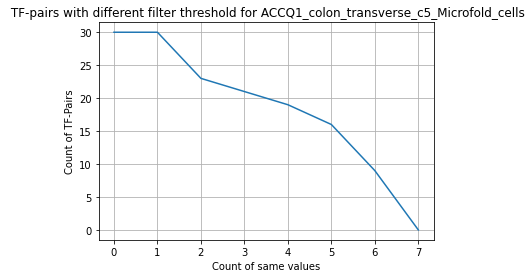

In [212]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='Count of cells with the same log2fc per contrast', ylabel='Count of TF-Pairs',
       title=' TF-pairs with different filter threshold for ACCQ1_colon_transverse_c5_Microfold_cells')
ax.grid()

#fig.savefig("test.png")
plt.show()

# OLD
# -----------------------------------------------------------------------------------------
# OLD

In [ ]:
# Analyses with whole diffcombj
diff_file_names=read_in_file_names_of_folder(rel_path=differential_analysis_path)

normalized_diff_objects = []
diff_objects = []

for file in diff_file_names:
    obj = DiffCombObj().from_pickle(f"{differential_analysis_path}{file}")
    if "normalized" in file:
        normalized_diff_objects.append(obj)
    else:
        diff_objects.append(obj)

print(normalized_diff_objects)
print(diff_objects) 

normalized_dfs = []
for obj in normalized_diff_objects:
    normalized_dfs.append(obj.rules)
print("Done: Preparing rules of DiffObj")    

In [ ]:
obj = normalized_diff_objects[0]
t = normalized_diff_objects[0].rules
t[t['right-lobe-of-liver.10_cosine'] > 0.7]
obj.rules

In [ ]:
results_df = []
for df in normalized_dfs:

    for i, file in enumerate(files_main_mb):
        # print(file)
        cluster_name = file.split('.pkl')[0]
        print(cluster_name)
        
        # reduce to relevant columns of cluster
        cluster_cols = list(filter(lambda x: f'{cluster_name}' in x , df.columns))
        # NOT WORKING: logfc_cluster_cols = list(filter(lambda x: (f'{cluster_name}/' || f'/{cluster_name}') in x , cluster_cols)) 
        # This is important: for right-lob-of-liver-1 ,     #right-lobe-of-liver.10_cosine
        logfc_cluster_cols = []
        for entry in cluster_cols:
            if (f'{cluster_name}/' in entry) or (f'/{cluster_name}_cosine_log2fc' in entry):
                logfc_cluster_cols.append(entry)
        
        #print(logfc_cluster_cols)
        print(len(logfc_cluster_cols))
        #print(logfc_cluster_cols)
        
        reduced_df = df[logfc_cluster_cols]
        print(f'Initial Count: {reduced_df.shape}')
        
        # Count all entries in a row , which do not have a zero(0.00) in it.
        # e.g. 15 cols have 0.00 => val_counts = 0, 10 cols not have a 0.00 => val_counts = 10 
        val_counts = reduced_df[~reduced_df.isin([0])].count(axis=1).sort_values()
        #print(tmp_val_counts)
        # Set threshold 
        selection_threshold = len(logfc_cluster_cols) # z.B 15 could be varyied
        
        ## Keep all entries,which do have more values different higher than the threshold
        tfs_occ = val_counts[val_counts >= selection_threshold].index
        result = reduced_df.loc[tfs_occ]
        print(f'Zero filtered: {result.shape}')
        
        significants = get_significant_log2fc_rules(result, threshold_percent=0.05)
        results_df.append(significants)
        print(f'Cluster: {cluster_name}: {significants.shape} ,tf-pairs with significant log2fc-changes in comparison to all the other clusters in tissue: {tissue_name} ')
         

In [ ]:
df1 = results_df[0]
print(df1.shape)
df1
# found tf-pairs, which have significant changes in comparison to all the other clusters in the tissue
# this 10 tf-pairs of cluster 10, show significant changes in comparion to all the other clusters in the tissue right lob of liver. 

#####  nur cosine werte vergleichbar, daher zum finden von spezifischen tf-cos nur cosines nutzen.  

In [ ]:
test = compare_obj.rules
df = pd.DataFrame(td.loc['EN2-MYBL2'])
df.head(50)
test

# nur cosine werte vergleichbar, daher zum finden von spezifischen tf-cos nur cosines nutzen.  
np.percentile(test['right-lobe-of-liver.11_cosine'], 75)


In [ ]:
test['right-lobe-of-liver.11_cosine'].describe()

In [ ]:
# cluster 6
df1 = results_df[13]
print(df1.shape)
df1.head(50)
df1.loc['Sox17-Dlx4':'TP63-FOSJUNB']

In [ ]:
# filtering if, nan values occure
filtered = df[logfc_cluster_cols]

val_counts = filtered.count(axis=1).sort_values()
#print(val_counts)
tfs_occ = val_counts[val_counts >=16].index
final = filtered.loc[tfs_occ]

In [ ]:
df = normalized_dfs[0]
cluster_name = "right-lobe-of-liver.1"
cluster_cols = list(filter(lambda x: f'{cluster_name}' in x , df.columns))
# NOT WORKING: logfc_cluster_cols = list(filter(lambda x: (f'{cluster_name}/' || f'/{cluster_name}') in x , cluster_cols)) 
# This is important: for right-lob-of-liver-1 
logfc_cluster_cols = []
for entry in cluster_cols:
    if (f'{cluster_name}/' in entry) or (f'/{cluster_name}_cosine_log2fc' in entry):
        logfc_cluster_cols.append(entry)
        
tmp = df[logfc_cluster_cols]
# wtf, tmp[~tmp.isin([0])]??
tmp_val_counts = tmp[~tmp.isin([0])].count(axis=1).sort_values()
#print(tmp_val_counts)
tmp_tfs_occ = tmp_val_counts[tmp_val_counts == len(logfc_cluster_cols)].index
result = tmp.loc[tmp_tfs_occ]
print(result.shape)
result

In [ ]:
df = normalized_dfs[0]
cluster_name = "right-lobe-of-liver.1"
cluster_cols = list(filter(lambda x: f'{cluster_name}' in x , df.columns))
# NOT WORKING: logfc_cluster_cols = list(filter(lambda x: (f'{cluster_name}/' || f'/{cluster_name}') in x , cluster_cols)) 
# This is important: for right-lob-of-liver-1 
logfc_cluster_cols = []
for entry in cluster_cols:
    if (f'{cluster_name}/' in entry) or (f'/{cluster_name}_cosine_log2fc' in entry):
        logfc_cluster_cols.append(entry)
        
tmp = df[logfc_cluster_cols]
tmp

In [ ]:
measure_threshold_1 = utils.get_threshold(result['right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc']
                                        , "both", percent=0.05)
measure_threshold_2 = utils.get_threshold(result['right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc']
                                        , "both", percent=0.05)
print(f'1: {measure_threshold_1}')
print(f'1: {measure_threshold_2}')

In [ ]:
measure_threshold_1[1]

In [ ]:
#t[t['right-lobe-of-liver.10_cosine'] > 0.7]
reduced_result_1 = result[(result['right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc'] > measure_threshold_1[1]) | (result['right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc'] < measure_threshold_1[0])]
reduced_result = reduced_result_1[(reduced_result_1['right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc'] > measure_threshold_2[1]) | (reduced_result_1['right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc'] < measure_threshold_2[0])]
reduced_result

In [ ]:
f.describe()

In [ ]:
m1 = pd.DataFrame(result.mean(axis=1), columns=['mean'])
m1['sum'] = result.sum(axis=1)
m1.plot.hist(by='mean', bins=100)
m1

In [ ]:
tmp = filtered.fillna(0)
tmp_val_counts = tmp[~tmp.isin([0])].count(axis=1).sort_values()

print(tmp_val_counts)
tmp_tfs_occ = tmp_val_counts[tmp_val_counts >=16].index
result = filtered.loc[tmp_tfs_occ]

m1 = pd.DataFrame(result.mean(axis=1), columns=['mean'])
m1['sum'] = result.sum(axis=1)
m1.plot.hist(by='mean', bins=100)

## Old: Self implemented - Differential analysis - comparing each cluster

In [ ]:
# mb market basket analysis
files_main_mb= read_in_file_names_of_folder(rel_path=main_analysis_path)
print(f"Count of Files: {len(files_main_mb)}")
print(f"Files: {files_main_mb}")


In [ ]:
# Diff analysis for all clusters of a tissue:
# TODO: what should be compared ? All of a Tissue? or All? Naming?
tissue_name = 'right-lobe-of-liver'
combObj_to_compare = []
for i, file in enumerate(files_main_mb):
    print(file)
    name_i = file.split('.pkl')[0]
    tissue_name = file.split('.')[0]
    obj = CombObj().from_pickle(f"{main_analysis_path}{file}")
    obj.set_prefix(name_i)
    #print(obj)
    combObj_to_compare.append(obj)
    
compare_obj = DiffCombObj(combObj_to_compare, measure="cosine", join="outer", fillna=True)
compare_obj.to_pickle(f'{differential_analysis_path}{tissue_name}.pkl')
compare_obj.normalize()
compare_obj.calculate_foldchanges()
compare_obj.simplify_rules()
compare_obj.to_pickle(f'{differential_analysis_path}{tissue_name}_normalized.pkl')
#selection does not work?
#selected_std = compare_obj.select_rules()
#selected_std.to_pickle(f'{differential_analysis_selection_path}{tissue_name}.pkl')
print("Done differential analysis")

In [ ]:
td = compare_obj.rules

tmp_val_counts = td[td.isin([0])].count(axis=1).sort_values()
#tmp_val_counts = td[td.isna()].count(axis=1).sort_values()

print(tmp_val_counts)
#tmp_tfs_occ = tmp_val_counts[tmp_val_counts >=16].index
#result = filtered.loc[tmp_tfs_occ]

In [ ]:
# check original market basket analysis for count of tf-cooccurences
print(compare_obj.rules.shape)
count_of_all = 0
count_of_all_significant = 0
for obj in combObj_to_compare:
    print(obj.prefix)
    print(obj.rules.shape)
    obj.simplify_rules()
    print(obj.rules.shape)
    count_of_all = count_of_all + obj.rules.shape[0]
    sig = obj.select_significant_rules()
    print(sig.rules.shape)
    count_of_all_significant = count_of_all_significant + sig.rules.shape[0]

print("all simplyfied for tissue")
print(count_of_all)    
print("all simplyfied for tissue and significant")
print(count_of_all_significant) 
   
    

In [ ]:
# Diff analysis between each cluster:
for i, file in enumerate(files_main_mb):
    print(file)
    name_i = file.split('.pkl')[0]
    
    for j in range(i + 1, len(files_main_mb), 1):
        file_j = files_main_mb[j]
        name_j = file_j.split('.pkl')[0]
        print(j)
        print(name_j)
        A = CombObj().from_pickle(f"{main_analysis_path}{file}")
        print(A)
        A.set_prefix(name_i)
        B = CombObj().from_pickle(f"{main_analysis_path}{file_j}")
        print(B)
        B.set_prefix(name_j)
        compare_obj = A.compare(B)
        compare_obj.to_pickle(f'{differential_analysis_path}{name_i}__{name_j}.pkl')
        
        selected_std = compare_obj.select_rules()
        
        #TODO: Save autamatically generated thresholds
        # utils.get_threshold(new.rules.iloc[:,4], 'both', percent=0.05)
        # logfc threshold (-xxx , +xxx)
        #  utils.get_threshold(new.rules.iloc[:,2:4].mean(axis=1), 'upper', percent=0.05)
        # cosine threshold
        selected_std.to_pickle(f'{differential_analysis_selection_path}{name_i}__{name_j}.pkl')
        
        break;
        
        
print("Done differential analysis")

## OLD implementation

In [ ]:
def prepare_diff_obj_dataframe(diff_obj: DiffCombObj) -> pd.DataFrame:
    
    # possible prefix names ['right-lobe-of-liver.10', 'right-lobe-of-liver.16']
    df = diff_obj.rules
    tissue_name_c1 , cluster_nr_c1  = diff_obj.prefixes[0].split('.')
    tissue_name_c2 , cluster_nr_c2  = diff_obj.prefixes[1].split('.')
    suff = ""
    if tissue_name_c1 == tissue_name_c2:
        suff += f"_{tissue_name_c1}"
    else:
        suff += f"_{tissue_name_c1}_{tissue_name_c2}"

    if cluster_nr_c1 == cluster_nr_c2:
        suff += f"_{cluster_nr_c1}"
    else:
        suff += f"_{cluster_nr_c1}_{cluster_nr_c2}"

    df['log2fc_class'] = df.apply(lambda x: 'negativ' if x[4] < 0 else 'positiv', axis=1)
    df.columns = [f'{x}{suff}' for x in df.columns]
    
    return df.copy(deep=True)


# Find the specific tf_cooccurences of a tissue that unique for the specific cluster in the tissue.
# 1. Diff analyse , 
# 2. Read in Diffanalyse for the specific cluster
# 3. Find tf-cooccurence of the diffob , which are occuring in each cluster
# Read in file Names of all analysis
files_main_mb= read_in_file_names_of_folder(rel_path=main_analysis_path)
print(f"Count of Files: {len(files_main_mb)}")
#print(f"Files: {files_main_mb}")

files_diff= read_in_file_names_of_folder(rel_path=differential_analysis_path)
print(f"Count of Files: {len(files_diff)}")

test = ""
for file_mb in files_main_mb:
    cluster_name = file_mb.split('.pkl')[0]
    print(cluster_name)
    diffs = list(filter(lambda x: cluster_name in x, files_diff))
    print(len(diffs))
    print(diffs)
    
    # Keeps the read in DiffCombObj diff_objects:
    diff_objects = []
    
    for diff in diffs:
        diff_obj = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}{diff}")
        diff_objects.append(diff_obj)
    
    erg = None
    for i in range(len(diff_objects)-1):
        
        if erg is None:
            obj_1= diff_objects[i]
            obj_2 = diff_objects[i + 1]
            df1 = prepare_diff_obj_dataframe(diff_obj = obj_1)
            df2 = prepare_diff_obj_dataframe(diff_obj = obj_2)
            
            erg = df1.merge(df2, how='outer', left_index=True, right_index=True)
        else:
            obj_2 = diff_objects[i + 1] 
            df2 = prepare_diff_obj_dataframe(diff_obj = obj_2)
            erg = erg.merge(df2, how='outer', left_index=True, right_index=True)
       
    test = erg
    erg.to_pickle(path=f"{answers_path}{cluster_name}.pkl")
    
print("Done")    
test.columns

In [ ]:
answer_file_names=read_in_file_names_of_folder(rel_path=answers_path)
print(answer_file_names)
cluster_dfs = []
df = None
for name in answer_file_names:
    df = pd.read_pickle(f"{answers_path}{name}")
    cluster_dfs.append(name)
    df = df

    #df.groupby(['class', 'value']).count()
    break;
filter_columns = list(filter(lambda x: 'log2fc_class' in x , df.columns))
#len(filter_columns)
filtered_df = df[df[filter_columns].notna().all(1)] #
filtered_df
df
#df3.iloc[:, 2:3]
#df = pd.read_pickle(f"{answers_path}right-lobe-of-liver.6.pkl")
#df = pd.read_pickle(f"{differential_analysis_selection_path}{right-lobe-of-liver.6.pkl}")


#original = CombObj().from_pickle(f"{main_analysis_path}right-lobe-of-liver.6.pkl")
#original.rules.loc[df.index]


In [ ]:
df = pd.read_pickle(f"{answers_path}right-lobe-of-liver.6.pkl")
selection = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}right-lobe-of-liver.10__right-lobe-of-liver.16.pkl")
selection_orig = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.10__right-lobe-of-liver.16.pkl")
selection_orig
selection

original = CombObj().from_pickle(f"{main_analysis_path}right-lobe-of-liver.6.pkl")
original.rules.loc[df.index]
selection.prefixes

### Try and Error section

In [ ]:
#mb_obj = CombObj().from_pickle(f"{main_analysis_path}right-lobe-of-liver.10.pkl")
obj_1 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.1.pkl")
obj_2 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.2.pkl")
obj_3 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.3.pkl")
obj_4 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.4.pkl")
obj_5 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.5.pkl")
obj_6 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.6.pkl")
#mb_obj.rules
#type(diff_obj.rules)
#diff_obj2.rules
df_diff = pd.concat([obj_1.rules, obj_2.rules, obj_3.rules, obj_4.rules, obj_5.rules, obj_6.rules], join="inner")



#df_diff2 = pd.concat([diff_obj_1_1.rules,diff_obj2.rules, diff_obj1_2.rules])

unified_duplicates = df_diff[df_diff.duplicated(subset=['TF1', 'TF2'], keep='first')]

df_diff2 = pd.concat([unified_duplicates, diff_obj1_2.rules])

unified_duplicates2 = df_diff2[df_diff2.duplicated(subset=['TF1', 'TF2'], keep='first')]

#df_diff = df_diff.drop_duplicates(subset=['TF1', 'TF2'])
#unified_duplicates
#unified_duplicates
#unified_duplicates2
#diff_obj_1_1.rules
#unified_duplicates



In [ ]:
obj_1 = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}right-lobe-of-liver.16__right-lobe-of-liver.1.pkl")
obj_2 = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}right-lobe-of-liver.16__right-lobe-of-liver.2.pkl")

obj_1.simplify_rules()
obj_2.simplify_rules()
obj3 = obj_1.rules.merge(obj_2.rules, left_index=True, right_index=True, suffixes=(f"_{obj_1.prefixes[0]}_{obj_1.prefixes[1]}", f"_{obj_2.prefixes[0]}_{obj_2.prefixes[1]}"))
obj3


In [ ]:
#df['log2fc_class'] = df.apply(lambda x: 'negativ' if x[4] < 0 else 'positiv', axis=1)

#removedNAN = df[df.notna().all(1)]

#df2 = removedNAN[(removedNAN[filter_columns] > 0.0) | (removedNAN[filter_columns] < 0.0)]
#df2[df2.notna().all(1)]
#filtered_df = df[df[filter_columns].notna().all(1)]

In [ ]:
diff_obj_1_1.rules.loc['Foxd3-ONECUT2']
diff_obj2.rules.loc['Foxd3-ONECUT2']

In [ ]:
top30C = selectedC.select_top_rules(n=30)
top30C.rules.head(31)

In [174]:
df1 = pd.DataFrame({
                    'value1': [-1, -3.33, 3, 6,4,7],
                    'value2': [-1, 3.33, 3.4, 9,2,7],
                    'value3': [1, -3.33, 3, 2,4,7],
                    'value4': [1, 3.33, 3, 1,9,7]},
                   index=['my1', 'my2', 'my3', 'my4', 'my5', 'my6'])
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo','test'],
                    'value': [5, 6, 7, 8, 9]},
                  index=['my1', 'not2', 'my3', 'not4', 'my5'])
df3 = pd.DataFrame({'rkey': ['new', 'lol'],
                    'value': [5, 6]},
                  index=['my1', 'not2'])
df1

#df1.merge(df2, left_on='lkey', right_on='rkey')
#erg = df1.merge(df2, left_index=True, right_index=True, suffixes=("_test", "_test2"))
#erg = df1.merge(df2, how='outer', left_index=True, right_index=True, suffixes=("_x", "_y"))
#erg = erg.merge(df3, how='outer', left_index=True, right_index=True, suffixes=("_x", "_"))
#erg


,value1,value2,value3,value4
my1,-1.00,-1.00,1.00,1.00
my2,-3.33,3.33,-3.33,3.33
my3,3.00,3.40,3.00,3.00
my4,6.00,9.00,2.00,1.00
my5,4.00,2.00,4.00,9.00
my6,7.00,7.00,7.00,7.00


In [91]:
df1[df1.apply(lambda x: min(abs(x)) == max(abs(x)), 1)]

,value1,value2,value3,value4
my1,-1.00,-1.00,1.00,1.00
my2,-3.33,3.33,-3.33,3.33
my6,7.00,7.00,7.00,7.00


In [175]:
df_abs = df1.abs()
df_abs

df_abs['num_uniq'] = df_abs.apply(pd.Series.nunique, axis=1)

In [176]:
df_abs

,value1,value2,value3,value4,num_uniq
my1,1.00,1.00,1.00,1.00,1
my2,3.33,3.33,3.33,3.33,1
my3,3.00,3.40,3.00,3.00,2
my4,6.00,9.00,2.00,1.00,4
my5,4.00,2.00,4.00,9.00,3
my6,7.00,7.00,7.00,7.00,1


In [92]:
def find_rows_with_same_value(df:pd.DataFrame) -> pd.DataFrame:
    '''
    Removes all rows of a Dataframe that do not have the same value in each column and
    returns the reduced dataframe.
    '''
    return df[df.apply(lambda x: find_value(x) , 1)]

In [179]:
def check_if_row_has_min_number_of_same_values(row, min_same_val=4):
    l = len(row.index)
    #print(l)
    count_same_val = 0
    i = 0
    for i in range(0, l - 1):
        j = i + 1
        while j < l:
            if abs(row[i]) == abs(row[j]):
                count_same_val = count_same_val + 1
            j = j+1
            
    #print(f'Count of same values in a row: {count_same_val}')   
    return (count_same_val >= min_same_val )

In [188]:
def check_if_row_has_min_number_of_same_values(row, min_same_val:int):
    '''
    Check if a row of a dataframe has a minumum count of same values in each column.
    Returns true if a minmum count of same values is reached.
    ---
    Parameters:
        row: pd.dataframe row,
            Contains the row of a dataframe, with the rows values.
        min_same_val: int,
            Threshold for minimum number of same values in the row.
    ---
    Return True or False
    '''
    l = len(row.index)
    abs_row = row.abs()
    count_of_distinct_value = abs_row.nunique()
    count_same_val = (l + 1) - count_of_distinct_value
    print(count_same_val)
    
    return (count_same_val >= min_same_val)

def find_rows_with_min_same_values(df:pd.DataFrame, min_same_val:int) -> pd.DataFrame:
    '''
    Remove all rows of a Dataframe that do not have a minimum count of same value in each column and
    return the reduced dataframe.
    '''
    
    return df[df.apply(lambda x: check_if_row_has_min_number_of_same_values(x, min_same_val=min_same_val), 1)]

In [195]:
find_rows_with_min_same_values(df1, min_same_val=4)

4
4
3
1
2
4


,value1,value2,value3,value4
my1,-1.00,-1.00,1.00,1.00
my2,-3.33,3.33,-3.33,3.33
my6,7.00,7.00,7.00,7.00


In [ ]:
df2.columns = [f'{x}_df2' for x in df2.columns]
df2

In [ ]:
[x+ 1 for x in df2.columns]

In [ ]:
df1['class'] = df1.apply(lambda x: 'niedrig' if x[1] < 5 else 'hoch', axis=1) 

In [ ]:
df1[df1['class'] == 'hoch']

In [ ]:
df1.groupby(['class', 'value']).count()

In [ ]:
df2

In [ ]:
df3.iloc[:, 2:3]

In [ ]:
top30C.plot_bubble()

In [ ]:
top30C.plot_network()

In [ ]:
selectedC.rules

In [ ]:
#### OLD 
# Find the specific tf_cooccurences of a tissue that unique for the specific cluster in the tissue.
# 1. Diff analyse , 
# 2. Read in Diffanalyse for the specific cluster
# 3. Find tf-cooccurence of the diffob , which are occuring in each cluster
# Read in file Names of all analysis
files_main_mb= read_in_file_names_of_folder(rel_path=main_analysis_path)
print(f"Count of Files: {len(files_main_mb)}")
#print(f"Files: {files_main_mb}")

files_diff= read_in_file_names_of_folder(rel_path=differential_analysis_path)
print(f"Count of Files: {len(files_diff)}")
#print(f"Files: {files_diff}")
test = ""
for file_mb in files_main_mb:
    cluster_name = file_mb.split('.pkl')[0]
    print(cluster_name)
    diffs = list(filter(lambda x: cluster_name in x, files_diff))
    print(len(diffs))
    print(diffs)
    
    # Keeps the read in DiffCombObj diff_objects:
    diff_objects = []
    
    for diff in diffs:
        diff_obj = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}{diff}")
        diff_objects.append(diff_obj)
    
    # erste DiffObj dataframe 
    initial_df = diff_objects[0].rules
    
    #has neg and pos foldchange
    cross_product_merged = initial_df
    
    # only pos foldchange
    pos_merged = initial_df[initial_df.iloc[:,4] > 0.00]
    
    # only neg foldchange
    neg_merged = initial_df[initial_df.iloc[:,4] < 0.00]
    for i in range(len(diff_objects)-1):
        obj_1= diff_objects[i]
        obj_2 = diff_objects[i + 1]
            
        # cross_product merge rules-dataframe by index (TF´s)
        cross_product = cross_product_merged.merge(obj_2.rules, left_index=True, right_index=True, suffixes=(f"_{obj_1.prefixes[0]}_{obj_1.prefixes[1]}", f"_{obj_2.prefixes[0]}_{obj_2.prefixes[1]}"))
        cross_product_merged = cross_product.copy(deep=True)
        
        # pos merge rules-dataframe by index (TF´s)
        obj2_df_pos = obj_2.rules[obj_2.rules.iloc[:,4] > 0.00]
        df_pos_merged = pos_merged.merge(obj2_df_pos, left_index=True, right_index=True, suffixes=(f"_{obj_1.prefixes[0]}_{obj_1.prefixes[1]}", f"_{obj_2.prefixes[0]}_{obj_2.prefixes[1]}"))
        pos_merged = df_pos_merged.copy(deep=True)
        
        # neg merge rules-dataframe by index (TF´s)
        obj2_df_neg = obj_2.rules[obj_2.rules.iloc[:,4] < 0.00]
        df_neg_merged = neg_merged.merge(obj2_df_neg, left_index=True, right_index=True, suffixes=(f"_{obj_1.prefixes[0]}_{obj_1.prefixes[1]}", f"_{obj_2.prefixes[0]}_{obj_2.prefixes[1]}"))
        neg_merged = df_neg_merged.copy(deep=True)
        
        
    cross_product_merged.to_pickle(path=f"{answers_path}{cluster_name}_cross.pkl")
    pos_merged.to_pickle(path=f"{answers_path}{cluster_name}_pos.pkl")
    neg_merged.to_pickle(path=f"{answers_path}{cluster_name}_neg.pkl")
    
print("Done")    
test
